In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import matplotlib.cm as cmx
from src.mssm.models import *

## Data structure

### How to prepare for your analysis:

We have data from multiple conditions. Thus a good starting point is to fit the first model discussed here (anything before: **Increasing complexity**) to separate data sets - one for each condition. Start maybe with the number of stages suggested from previous experiments (since model comparisons are not working yet). That way you don't have to change anything (except for the ``n_j`` parameter) about the model. You can use the ``utils.create_event_matrix_time`` function and rely on the penalty code I wrote.

You can even set ``cov = [None for s in range(n_s)]``, because we don't have random effects in the simplest model.

Then you need to only provide ``y_mat``, ``time``, and ``trial_end``. The last one should simply be the **sample** (or the closest one) matching the response time point. ``y_mat`` needs to be a ``list`` of ``np.arrays`` - one array per series. ``time`` needs to be of the same dimension and type structure (i.e., a list of arrays) as ``y_mat`` and should simply contain the time-series matching the observation values included in ``y_mat``.

##### Example:

If your trials are down-sampled to 50 Hz (20 ms per sample) and you have a trial ``s`` that ends after 800 ms, then ``trial_end[s]=40``. Let's say you include data from stimulus onset to 1.5 seconds after response onset, then both ``y_mat[s]`` and ``time[s]`` should have a length of 115 (115 samples times 20 ms = 800 ms until response + 1500 ms). ``y_mat[s]`` should contain the pupil size at each of those 115 samples while ``time[s]`` should contain the **time-points** corresponding to those samples. That is ``time[s][0:5] = np.array([0, 20, 40, 60, 80])``.

In [2]:
# Import some simulated data
n_s = 100
y_mat = list(np.load("./data/dcGAMM/no_rand/series.npy"))[0:n_s]
time = list(np.load("./data/dcGAMM/no_rand/time_series.npy"))[0:n_s]
series_end = list(np.load("./data/dcGAMM/no_rand/trial_ends.npy"))[0:n_s]
cov = list(np.load("./data/dcGAMM/no_rand/covariates.npy"))[0:n_s]
# cov = [None for s in range(n_s)] # Works for first model as well!

In [3]:
dat = pd.DataFrame({"y":[y for s in y_mat for y in s],
                   "time":[t for s in time for t in s],
                   "series":[c for s in cov for c in s]})
dat = dat.astype({'series': 'O'})

In [4]:
dat

,y,time,series
0,NaN,0.0,0
1,NaN,20.0,0
2,NaN,40.0,0
3,NaN,60.0,0
4,NaN,80.0,0
...,...,...,...
15095,-3.310726,2920.0,99
15096,-3.034704,2940.0,99
15097,-0.312104,2960.0,99
15098,-1.015362,2980.0,99


## Model setup

1) Define initial parameters
    1.1) Penalties
2) Define the model
    2.1) Model matrix function
3) Run the model
4) Visualize

## Defining the model

In [5]:
formula = Formula(lhs("y"),
                  [irf(["time"],0,nk=15,basis_kwargs={"max_c":2500,"convolve":True}),
                   irf(["time"],1,nk=15,basis_kwargs={"max_c":2500,"convolve":True}),
                   irf(["time"],2,nk=15,basis_kwargs={"max_c":2500,"convolve":True}),
                   irf(["time"],3,nk=15,basis_kwargs={"max_c":2500,"convolve":True}),
                   ri("series")],
                   data=dat,
                   series_id="series")

pformula = PFormula([PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0})])

fix = None

model = sMsIRGAMM(formula,Gaussian(),pformula,series_end,fix,cpus=4)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:594: UserWarning: 2339 y values (15.49%) are NA.
  warnings.warn(f"{data.shape[0] - data[NAs_flat].shape[0]} {self.get_lhs().variable} values ({round((data.shape[0] - data[NAs_flat].shape[0]) / data.shape[0] * 100,ndigits=2)}%) are NA.")


In [6]:
llk_hist,states_flat,states = model.fit(t0=0.25)

## Visualization

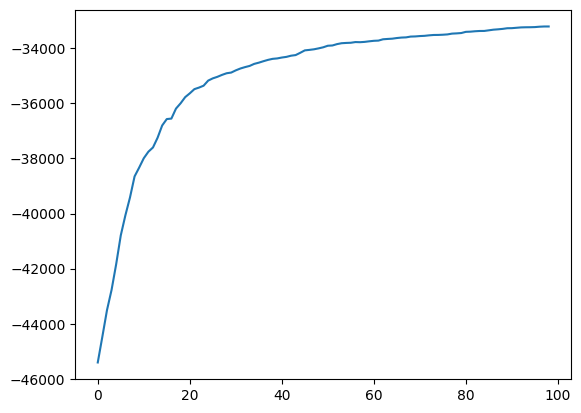

In [7]:
# Convergence
plt.plot(llk_hist)
plt.show()

In [8]:
# We can get the recovered parameters with this function!
coef,sigma = model.get_pars()

In [9]:
# coef contains for every column in the model matrix the associated weight
print(coef[0:20])

[-3.52441399e+00  1.40774146e-01  7.51941042e-02  2.99678292e+00
  2.61173149e+01  6.58191428e+01  7.99762044e+01  6.02881732e+01
  2.71273880e+01  5.59978467e+00 -2.44130895e+00 -3.16662719e+00
 -1.64316867e+00 -6.94551024e-01  6.32059825e-02  1.88375019e+00
 -6.93432995e-01 -5.36130167e-02 -7.99871146e-01 -1.55389576e+01]


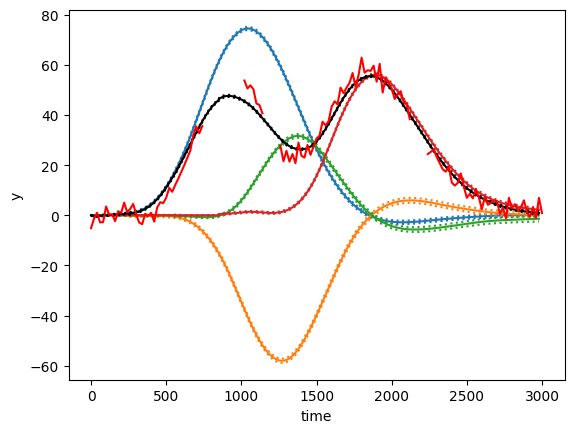

In [10]:
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

s = 63 # series to look at

for si in range(4):
    # Set up some new data for prediction
    time_pred = np.arange(0,3000,20)
    new_dat = pd.DataFrame({"time":time_pred,
                            "series":[s for _ in range(len(time_pred))]})
    
    # Make prediction using only individual impulse responses.
    pred,_,b = model.predict(states[s],[si],new_dat,ci=True,alpha=0.05)
    plt.plot(time_pred,pred,color=colors[si])
    plt.plot(time_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(time_pred,pred-b,color=colors[si], linestyle='dotted')

# Additive prediction = sum over all impulse responses = recovered signal.
pred,_,b = model.predict(states[s],None,new_dat,ci=True,alpha=0.05)
plt.plot(time_pred,pred,color='black')
plt.plot(time_pred,pred+b,color='black', linestyle='dotted')
plt.plot(time_pred,pred-b,color='black', linestyle='dotted')

# Plot observed series.
plt.plot(dat["time"][dat["series"] == s],
         dat["y"][dat["series"] == s],color='red')

plt.xlabel("time")
plt.ylabel("y")
plt.show()